In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import networkx as nx
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import RandomForestRegressor




df = pd.read_csv('CNC_Machine.csv')
df_clean = df.drop(columns=["Unnamed: 0", "filename"], errors='ignore')
df_clean.fillna(df_clean.median(), inplace=True)



In [20]:
print(f"Original shape: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"Target stats:\n{df_clean['average_power_consumption'].describe()}")

Original shape: (220, 19)
Missing values: 0
Target stats:
count     220.000000
mean     2835.372458
std       720.797069
min      1552.895455
25%      2181.747535
50%      2865.267542
75%      3451.490151
max      4355.949333
Name: average_power_consumption, dtype: float64


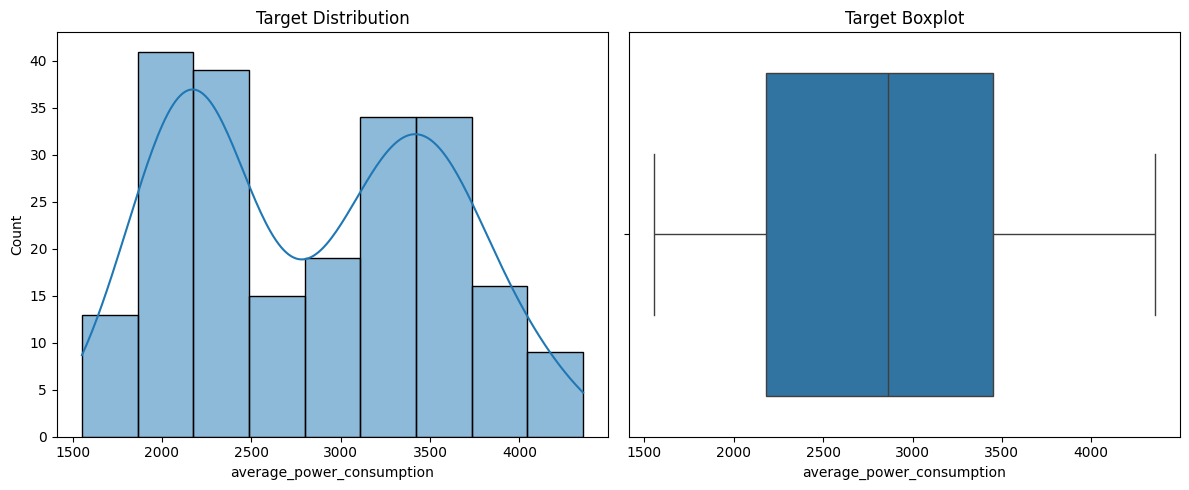

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['average_power_consumption'], kde=True)
plt.title('Target Distribution')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_clean['average_power_consumption'])
plt.title('Target Boxplot')
plt.tight_layout()
plt.show()

In [22]:
target_var = "average_power_consumption"
X = df_clean.drop(columns=[target_var])
y = df_clean[target_var]

if y.skew() > 1:
    y = np.log1p(y)
    print("\nApplied log transformation to target variable")

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [24]:
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_val_scaled = feature_scaler.transform(X_val)
X_test_scaled = feature_scaler.transform(X_test)

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f"\n=== Feature Shapes ===")
print(f"Train: {X_train_poly.shape}, Val: {X_val_poly.shape}, Test: {X_test_poly.shape}")


=== Feature Shapes ===
Train: (140, 189), Val: (36, 189), Test: (44, 189)


In [25]:
class PowerConsumptionPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.net(x)


In [26]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_poly), torch.FloatTensor(y_train_scaled))
val_dataset = TensorDataset(torch.FloatTensor(X_val_poly), torch.FloatTensor(y_val_scaled))

In [27]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [28]:
model = PowerConsumptionPredictor(X_train_poly.shape[1])
criterion = nn.HuberLoss()  #More robust to outliers
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [29]:
def train_model(model, train_loader, val_loader, epochs=500):
    best_loss = float('inf')
    patience = 30
    counter = 0
    history = {'train': [], 'val': []}

    for epoch in range(epochs):
        #Training phase
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).flatten()
            loss = criterion(outputs, targets)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs).flatten()
                val_loss += criterion(outputs, targets).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        scheduler.step(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"\nEarly stopping at epoch {epoch}")
                break
        
        if epoch % 50 == 0 or epoch == epochs - 1:
            lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {lr:.2e}")

    return history

print("\n=== Training Started ===")
history = train_model(model, train_loader, val_loader, epochs=500)


=== Training Started ===
Epoch   0 | Train Loss: 0.4300 | Val Loss: 0.4538 | LR: 1.00e-03
Epoch  50 | Train Loss: 0.0851 | Val Loss: 0.0989 | LR: 3.13e-05

Early stopping at epoch 55


In [30]:
model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [31]:
model.eval()
with torch.no_grad():

    test_tensor = torch.FloatTensor(X_test_poly)
    scaled_preds = model(test_tensor).numpy().flatten()
    
    predictions = target_scaler.inverse_transform(scaled_preds.reshape(-1, 1)).flatten()

    if y.skew() > 1:
        predictions = np.expm1(predictions)
        y_test = np.expm1(y_test)
    
    test_loss = criterion(torch.FloatTensor(scaled_preds), torch.FloatTensor(y_test_scaled))
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)

    print("\n=== Final Evaluation ===")
    print(f"Test Loss (scaled): {test_loss.item():.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Target Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")




=== Final Evaluation ===
Test Loss (scaled): 0.0554
R2 Score: 0.8791
MAE: 168.7116
Target Mean: 2843.23, Std: 695.30


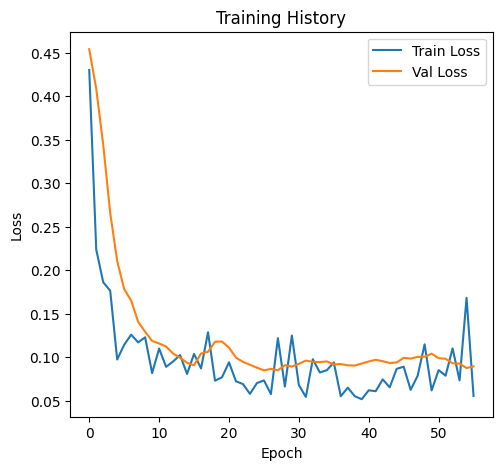

In [32]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train'], label='Train Loss')
plt.plot(history['val'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()

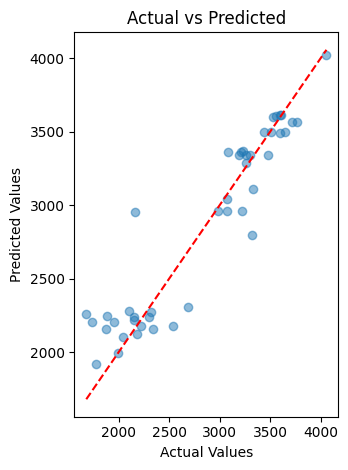

In [33]:
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.tight_layout()
plt.show()

In [34]:
print("\n=== Feature Importance Analysis ===")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)


=== Feature Importance Analysis ===


RandomForestRegressor(random_state=42)

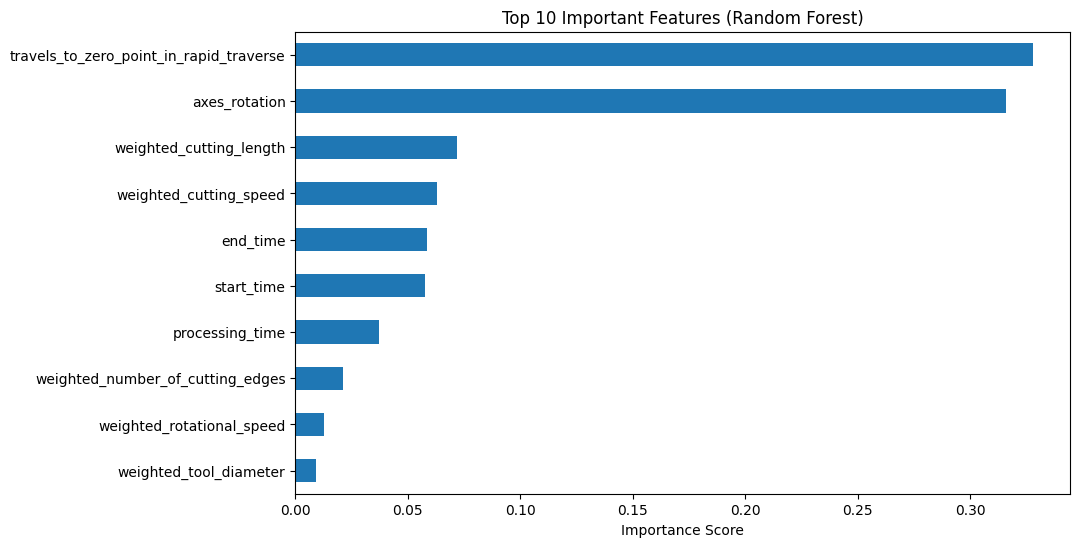

In [35]:
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
top_features = feature_importance.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_features.sort_values().plot.barh()
plt.title('Top 10 Important Features (Random Forest)')
plt.xlabel('Importance Score')
plt.show()

In [36]:
corr_matrix = pd.DataFrame(X_train_scaled, columns=X.columns).corrwith(pd.Series(y_train_scaled))
top_correlated = corr_matrix.abs().sort_values(ascending=False).head(10)

print("\nTop correlated features with target:")
print(top_correlated)


Top correlated features with target:
tool_changes                               0.590365
travels_to_zero_point_in_rapid_traverse    0.539811
axes_rotation                              0.539811
weighted_rotational_speed                  0.492986
processing_time                            0.470196
weighted_cutting_length                    0.451019
raw_volume                                 0.435073
start_time                                 0.405142
end_time                                   0.404856
weighted_tool_diameter                     0.347909
dtype: float64


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
